# Fibermagic Tutorial 2 - Batch Processing

Welcome to the second tutorial on batch processing fiber photometry data with Fibermagic! 

In this tutorial, we'll build on what we learned previously about processing single sessions and scale it up to handle multiple experimental sessions efficiently. Rather than processing each session individually, we'll learn how to analyze multiple sessions simultaneously - a common requirement when working with neuroscience data from multiple animals across different recording days.

## Experimental Setup

We'll analyze data from 6 mice, with 2 recording sessions per mouse (12 sessions total). The data was collected using a multi-fiber patch cable that allowed simultaneous recording from all mice during each session.

The data is organized as follows:
```
fibermagic_tutorial_2/
├── session_1/
│   ├── photometry.csv       # Fiber photometry signals for n = 6 mice
│   ├── time.csv             # Timestamp data
│   ├── region_to_mouse.csv  # Mapping between recording channels and mice
│   └── logs.csv             # Behavioral event logs
└── session_2/
    ├── photometry.csv
    ├── time.csv
    ├── region_to_mouse.csv
    └── logs.csv
```

Note: Since all mice were recorded simultaneously, each session folder contains a single set of data files covering all animals.

## Tutorial Overview

We will:
1. Load and combine photometry data from all 12 sessions
2. Integrate behavioral events with the photometry signals
3. Apply signal processing (detrending and standardization)
4. Calculate peri-event zdFF traces for each session
5. Generate grand average plots across all sessions

## Loading the data

Similar to the previous tutorial, we can use the function `read_npm` to load the photometry data for each session. The following cell:
1. Downloads the example dataset from the `fibermagic` cloud. It's about **63 MB**, so it will take a couple of seconds to download.
2. Loads the **photometry data** for the first and second session separately.
3. Adds a column to the dataframes that contains the **session** name, such that we know which session the data belongs to.
4. Combines the two dataframes into a single dataframe.
5. Uses the `region_to_mouse.csv` file to map the recording channels to the mice and camera sensors. This file tells us which recording channel corresponds to which mouse and to what camera sensor (red, 560nm, or green, 470nm).


In [205]:
import pandas as pd
import sys
sys.path.append(r'C:\Users\Georg\Git\fibermagic')
%load_ext autoreload
%autoreload 2
import fibermagic
from pathlib import Path

base_path = Path('fibermagic_tutorial_2')
fibermagic.download('tutorial-2')  # 63 MB

df_1 = fibermagic.read_npm(
    photometry_path=base_path / 'session_1' / 'photometry.csv',
    extra_timestamps_path=base_path / 'session_1' / 'time.csv',
    region_to_mouse_path=base_path / 'session_1' / 'region_to_mouse.csv'
)
df_1['session'] = 'session_1'

df_2 = fibermagic.read_npm(
    photometry_path=base_path / 'session_2' / 'photometry.csv',
    extra_timestamps_path=base_path / 'session_2' / 'time.csv',
    region_to_mouse_path=base_path / 'session_2' / 'region_to_mouse.csv'
)
df_2['session'] = 'session_2'

df = pd.concat([df_1, df_2])
df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,datetimestamp,red_signal,green_signal,red_reference,green_reference,mouse,Time (sec),session
1,2022-08-25 18:17:18.501862400,0.003922,0.004076,0.004330,0.003922,B3644,0.064781,session_1
2,2022-08-25 18:17:18.541670400,0.004021,0.004033,0.004351,0.003922,B3644,0.104589,session_1
3,2022-08-25 18:17:18.581312000,0.004018,0.004058,0.004360,0.003922,B3644,0.144230,session_1
4,2022-08-25 18:17:18.621440000,0.004021,0.004055,0.004328,0.003922,B3644,0.184358,session_1
5,2022-08-25 18:17:18.661440000,0.004026,0.004079,0.004311,0.003922,B3644,0.224358,session_1
...,...,...,...,...,...,...,...,...
677809,2022-08-27 18:26:25.190208000,0.021858,0.004152,0.021324,0.003922,B3636,4518.670221,session_2
677810,2022-08-27 18:26:25.230028800,0.021948,0.004147,0.021298,0.003922,B3636,4518.710042,session_2
677811,2022-08-27 18:26:25.270080000,0.021886,0.004174,0.021304,0.003922,B3636,4518.750093,session_2
677812,2022-08-27 18:26:25.310400000,0.021925,0.004129,0.021249,0.003922,B3636,4518.790413,session_2


This DataFrame is much bigger than the one from the previous tutorial, it contains > 1.3 million rows. Can our computer handle it? Let's find out:


In [206]:
# Get size of dataframe in RAM in MB
df_size_mb = df.memory_usage(deep=True).sum() / 1024 / 1024
print(f"Size of dataframe in RAM: {df_size_mb:.2f} MB")

Size of dataframe in RAM: 235.52 MB


Only about 160 MB are used, so there is plenty of memory left! Having the entire dataset in memory will solve us a lot of time and headaches later on.

If you are still confused, about `region_to_mouse.csv`: Let's just look at the first few rows to understand what it contains. Later, you can just edit the file and adapt it to your experiment


In [207]:
pd.read_csv(base_path / 'session_1' / 'region_to_mouse.csv').head()

,region,mouse,wave_len
0,Region0R,B3644,560
1,Region1G,B3644,470
2,Region2R,B3645,560
3,Region3G,B3645,470
4,Region6R,B3637,560


# Loading and Merging Events

Now, let's load the events and merge them with the photometry data.

Again, we have one file per session that contains events like `lever press` or `food pellet`. We can load both `logs.csv` files and merge them into a single dataframe:

In [208]:
header = ['datetimestamp', 'mouse', 'event']
events_1 = pd.read_csv(base_path / 'session_1' / 'logs.csv', header=None, names=header, delimiter=';')
events_1['session'] = 'session_1'
events_2 = pd.read_csv(base_path / 'session_2' / 'logs.csv', header=None, names=header, delimiter=';')
events_2['session'] = 'session_2'
events = pd.concat([events_1, events_2])

# Filter events to only include mice that are present in the photometry data
events = events[events.mouse.isin(df.mouse.unique())]
events



,datetimestamp,mouse,event,session
15,2022-08-25T18:32:58.0077824,B3637,video_start,session_1
16,2022-08-25T18:33:06.0835072,B3637,LL,session_1
17,2022-08-25T18:33:13.8775296,B3637,RL,session_1
18,2022-08-25T18:33:14.0290304,B3637,RL,session_1
19,2022-08-25T18:33:17.8262400,B3637,RL,session_1
...,...,...,...,...
3969,2022-08-27T18:20:40.7238528,B3645,FD,session_2
3970,2022-08-27T18:21:16.6640896,B3645,RL,session_2
3971,2022-08-27T18:21:16.6677504,B3645,video_stop,session_2
3972,2022-08-27T18:25:38.8994560,B3645,RL,session_2


### The "BY" argument

Now, we can merge the events with the photometry data.

But there is a problem: We don't simply want to merge every event onto the closest timestamp in the photometry data. We actually need to look at the **mouse** and **session** of the event and merge it onto the closest timestamp in the photometry data for that mouse and session.

Luckily, `fibermagic` takes care of this for us! We just need to specify the `by` argument, which tells `fibermagic` which columns to group by. In this case, we want to group by `mouse` and `session`. We can think of it like this: Fibermagic will first split the data into groups according to the `by` argument, and then merge the events onto the closest timestamp in the photometry data for each group. That way, we make sure that we process all sessions and mice independently. Keep `by` in mind when you are using other functions, like `perievents` or `demodulate`, as they also have a `by` argument.


In [209]:
df = fibermagic.merge_events(df, events=events, start_event='video_start', stop_event='video_stop', 
                             datetime_col='datetimestamp', by=['mouse', 'session'])
df

,datetimestamp,red_signal,green_signal,red_reference,green_reference,mouse,Time (sec),session,event
0,2022-08-25 18:45:09.052352000,0.012446,0.006818,0.004850,0.003925,B3636,0.000000,session_1,video_start
1,2022-08-25 18:45:09.090598400,0.012367,0.006806,0.004918,0.003929,B3636,0.038246,session_1,NaN
2,2022-08-25 18:45:09.130918400,0.012393,0.006875,0.004901,0.003928,B3636,0.078566,session_1,NaN
3,2022-08-25 18:45:09.172198400,0.012406,0.006836,0.004946,0.003928,B3636,0.119846,session_1,NaN
4,2022-08-25 18:45:09.212070400,0.012378,0.006832,0.004917,0.003927,B3636,0.159718,session_1,NaN
...,...,...,...,...,...,...,...,...,...
790035,2022-08-27 18:21:16.544742400,0.009909,0.003936,0.003949,0.003922,B3645,2680.450150,session_2,NaN
790036,2022-08-27 18:21:16.585062400,0.009870,0.003932,0.003943,0.003922,B3645,2680.490470,session_2,NaN
790037,2022-08-27 18:21:16.625152000,0.009895,0.003931,0.003939,0.003922,B3645,2680.530560,session_2,NaN
790038,2022-08-27 18:21:16.665036800,0.009877,0.003937,0.003948,0.003922,B3645,2680.570445,session_2,RL


### Let's print a summary of the events to see how many events which mouse and session has:

Here's the explanation of each event type:
- `video_start`: The start of the experimental session.
- `video_stop`: The end of the experimental session.
- `LL`: Left lever press.
- `LR`: Right lever press.
- `FD`: Food pellet dispensed.
- `P_LL=0.06_RL=0.2`: The probability that the left lever is rewarded changes to 6% and the right lever to 20%.
- `P_LL=0.2_RL=0.06`: The probability that the left lever is rewarded changes to 20% and the right lever to 6%.


In [210]:
# Group by session and mouse, count occurrences of each event type
events.groupby(['session', 'mouse'])['event'].value_counts().unstack(fill_value=0)

event            FD   LL  P_LL=0.06_RL=0.2  P_LL=0.2_RL=0.06   RL  \
session   mouse                                                     
session_1 B3636  37   89                 4                 4  163   
          B3637  64  180                 4                 5  178   
          B3638  26  111                 3                 4  114   
          B3639  21  113                 4                 5  126   
          B3644  53  348                 5                 4   90   
          B3645  42   75                 4                 4  258   
session_2 B3636  28   95                 4                 4  165   
          B3637  41  186                 5                 4  177   
          B3638  28   52                 3                 4  118   
          B3639  25   81                 4                 4  114   
          B3644  69  308                 4                 3   63   
          B3645  18  126                 4                 4   92   

event            video_start  video_stop  
session   mouse                           
session_1 B3636            1           1  
          B3637            1           1  
          B3638            1           1  
          B3639            1           1  
          B3644            1           1  
          B3645            1           1  
session_2 B3636            1           1  
          B3637            1           1  
          B3638            1           1  
          B3639            1           1  
          B3644            1           1  
          B3645            2           2

# Detrending and Standardization

Now, we can detrend and standardize the data.

This step is the same as in the previous tutorial. We use the `demodulate` function to detrend and standardize the data.

The only difference is that we now also specify the `by` argument, which tells `fibermagic` which columns to group by. In this case, we want to group by `mouse` and `session`.


In [211]:
df['DA zdFF'] = fibermagic.demodulate(data=df, timestamps='Time (sec)', signal='red_signal', 
                                      isosbestic='red_reference', standardize=True, by=['mouse', 'session'])
df['ACh zdFF'] = fibermagic.demodulate(data=df, timestamps='Time (sec)', signal='green_signal', 
                                       isosbestic='red_reference', standardize=True, by=['mouse', 'session'])
df

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

,datetimestamp,red_signal,green_signal,red_reference,green_reference,mouse,Time (sec),session,event,DA zdFF,ACh zdFF
0,2022-08-25 18:45:09.052352000,0.012446,0.006818,0.004850,0.003925,B3636,0.000000,session_1,video_start,4.466310,0.551249
1,2022-08-25 18:45:09.090598400,0.012367,0.006806,0.004918,0.003929,B3636,0.038246,session_1,NaN,3.623987,0.022560
2,2022-08-25 18:45:09.130918400,0.012393,0.006875,0.004901,0.003928,B3636,0.078566,session_1,NaN,3.873519,1.947973
3,2022-08-25 18:45:09.172198400,0.012406,0.006836,0.004946,0.003928,B3636,0.119846,session_1,NaN,3.618043,0.753722
4,2022-08-25 18:45:09.212070400,0.012378,0.006832,0.004917,0.003927,B3636,0.159718,session_1,NaN,3.684896,0.732007
...,...,...,...,...,...,...,...,...,...,...,...
790035,2022-08-27 18:21:16.544742400,0.009909,0.003936,0.003949,0.003922,B3645,2680.450150,session_2,NaN,0.132871,0.070762
790036,2022-08-27 18:21:16.585062400,0.009870,0.003932,0.003943,0.003922,B3645,2680.490470,session_2,NaN,-0.066073,-0.760985
790037,2022-08-27 18:21:16.625152000,0.009895,0.003931,0.003939,0.003922,B3645,2680.530560,session_2,NaN,0.065989,-0.968917
790038,2022-08-27 18:21:16.665036800,0.009877,0.003937,0.003948,0.003922,B3645,2680.570445,session_2,RL,-0.032460,0.278738


# Peri-event zdFF

Now, we can calculate the peri-event zdFF traces.

This step is the same as in the previous tutorial. We use the `perievents` function to calculate the peri-event zdFF traces.

Note again that we specify the `by` argument, which tells `fibermagic` which columns to group by. In this case, we want to group by `mouse` and `session`.


In [212]:
peri = fibermagic.perievents(df, time_column='Time (sec)', event_column='event', data_columns=['DA zdFF', 'ACh zdFF'], 
                             window=5, only_average=False, by=['mouse', 'session'])
peri

  0%|          | 0/12 [00:00<?, ?it/s]

,mouse,session,Event,Trial,Relative Time,Time (sec),DA zdFF,ACh zdFF
0,B3636,session_1,RL,0,-5.000000,4.118374,3.288941,0.493361
1,B3636,session_1,RL,0,-4.966667,4.158797,3.242087,0.804610
2,B3636,session_1,RL,0,-4.933333,4.199744,2.850630,1.448805
3,B3636,session_1,RL,0,-4.900000,4.199744,2.850630,1.448805
4,B3636,session_1,RL,0,-4.866667,4.238682,2.899100,0.697668
...,...,...,...,...,...,...,...,...
1184995,B3645,session_2,P_LL=0.2_RL=0.06,3,4.833333,2463.166694,-0.640264,1.423488
1184996,B3645,session_2,P_LL=0.2_RL=0.06,3,4.866667,2463.206618,-0.740976,0.384005
1184997,B3645,session_2,P_LL=0.2_RL=0.06,3,4.900000,2463.206618,-0.740976,0.384005
1184998,B3645,session_2,P_LL=0.2_RL=0.06,3,4.933333,2463.246669,-0.711099,0.592027


### Visualizing Neural Activity Around Food Reward Events

Now we'll analyze how dopamine and acetylcholine signals change around food reward delivery events. This provides insight into the neural dynamics associated with reward processing.

The following code will:
1. Extract neural activity data specifically around food delivery (`FD`) events
2. Generate a comprehensive visualization with subplots for each mouse and experimental session
3. Display the average dopamine (red) and acetylcholine (green) activity traces
4. Include standard error of the mean (SEM) bands to show variability

This allows us to examine both the consistency and variability of neural responses to food rewards across different animals and sessions.

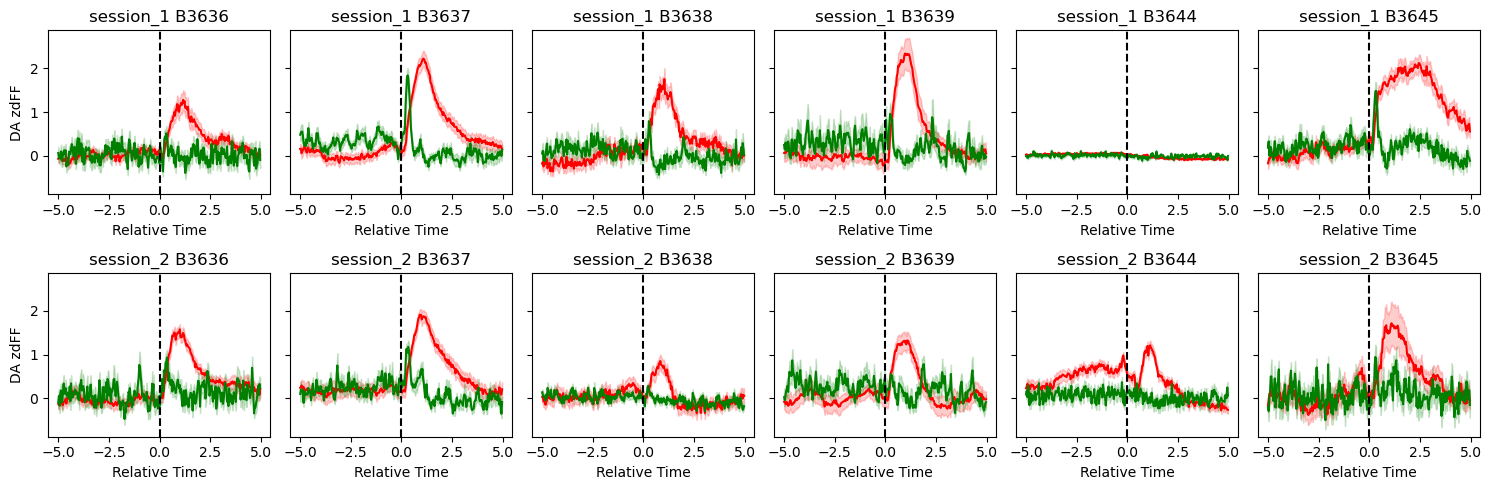

In [213]:
import seaborn as sns
import matplotlib.pyplot as plt

fd_peri = peri[peri.Event=='FD'].copy()

fig, axs = plt.subplots(nrows=len(fd_peri['session'].unique()), ncols=len(fd_peri['mouse'].unique()), figsize=(15, 5), sharey=True)
for i, session in enumerate(fd_peri['session'].unique()):
    for j, mouse in enumerate(fd_peri['mouse'].unique()):
        sns.lineplot(data=fd_peri[(fd_peri['session'] == session) & (fd_peri['mouse'] == mouse)].copy(), x='Relative Time', y='DA zdFF', ax=axs[i, j], color='red', errorbar='se')
        sns.lineplot(data=fd_peri[(fd_peri['session'] == session) & (fd_peri['mouse'] == mouse)].copy(), x='Relative Time', y='ACh zdFF', ax=axs[i, j], color='green', errorbar='se')
        axs[i, j].set_title(f'{session} {mouse}')
        axs[i, j].axvline(x=0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


# Computing and Plotting the Grand Average Response

After examining individual mouse data above, we identified that mouse `B3644` shows anomalous signals that warrant exclusion from further analysis. This highlights the importance of inspecting individual subject data before proceeding with group-level analyses.

Our primary interest lies in identifying consistent neural response patterns across animals, rather than individual variations. For example, we want to determine if there is a reliable dopamine increase following reward-predicting cues across all subjects. Here's how we'll analyze this:

1. We'll recompute peri-event averages using `only_average=True`. This parameter collapses individual trials into a single average trace for each **mouse** and **session** combination (specified by `by=['mouse', 'session']`).

2. We'll then create a group-level visualization using seaborn. This generates a "grand average" - an average of the individual mouse averages - along with the standard error of the mean (SEM) shown as shaded regions. This two-step averaging process (first within subjects, then across subjects) ensures equal weighting of each animal regardless of their trial counts. For example, if mouse A has 10 trials and mouse B has 100 trials, a single-step average would be heavily biased toward mouse B's data. Our approach better reveals whether neural response patterns are truly consistent across different subjects.

  0%|          | 0/10 [00:00<?, ?it/s]

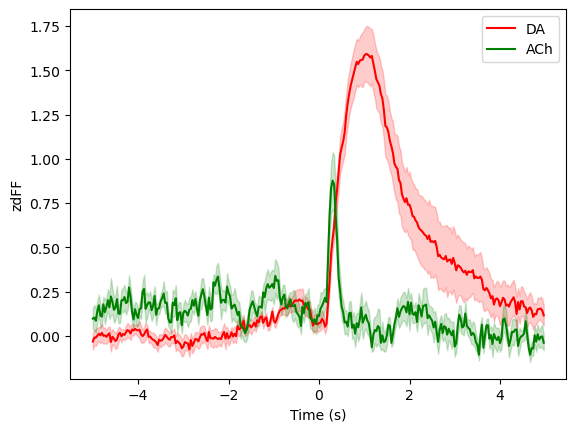

In [215]:
avg_peri = fibermagic.perievents(df[df.mouse != 'B3644'], time_column='Time (sec)', event_column='event', data_columns=['DA zdFF', 'ACh zdFF'], 
                             window=5, only_average=True, by=['mouse', 'session'])

fd_avg_peri = avg_peri[avg_peri.Event=='FD'].copy()
sns.lineplot(data=fd_avg_peri, x='Relative Time', y='DA zdFF', color='red', errorbar='se', label='DA')
sns.lineplot(data=fd_avg_peri, x='Relative Time', y='ACh zdFF', color='green', errorbar='se', label='ACh')
plt.ylabel('zdFF')
plt.xlabel('Time (s)')
plt.legend()